In [1]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import random
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input,LSTM,Dropout,Dense,Bidirectional,Conv2D,Embedding,Masking,TimeDistributed,MaxPool2D
from tensorflow.keras.layers import Reshape,Lambda,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

<h1>1. Load featurized data

In [2]:
[X_train,y_train,X_val,y_val,X_test,y_test,embedding_matrix,tokenizer,label_index] = joblib.load('utils')

In [3]:
print(X_train.shape)
print(y_train.shape)
print(embedding_matrix.shape)

(1093, 24, 35)
(1093, 24)
(5243, 300)


In [4]:
label_index

{'anger': 4,
 'disgust': 7,
 'fear': 6,
 'joy': 2,
 'neutral': 1,
 'sadness': 5,
 'surprise': 3}

In [5]:
classes = len(label_index)
classes

7

In [6]:
vocab_size = embedding_matrix.shape[0]
vocab_size

5243

In [7]:
#Maximum words in any utterance
max_sentence_length = 35
#Maximum utterances in a dialogue
max_utterances = 24

<h1>2. Modelling

<h2>2.1. Model Architecture

In [8]:
def get_model():
    
    inputs = Input(shape=(max_utterances,max_sentence_length),name='Input_layer',dtype='int32')

    #Extract one utterance
    def slicer(x, index):
        return x[:,K.constant(index, dtype='int32'),:]
    def slicer_output_shape(input_shape):
        #shape == (Batch size, utterances, sentence_length)
        shape = list(input_shape)
        new_shape = (shape[0], shape[2])
        return new_shape

    #Add one dimension to embedding layer output
    def reshaper(x):
            return K.expand_dims(x, axis=3)

    #Flatten
    def flattener(x):
        x = K.reshape(x, [-1, x.shape[1]*x.shape[3]])
        return x
    def flattener_output_shape(input_shape):
        shape = list(input_shape)
        #Multipy by 3 due to 3 filters
        new_shape = (shape[0], 3*shape[3])
        return new_shape

    embedding = Embedding(input_dim=vocab_size,output_dim=300,input_length=max_sentence_length,
                          name='Embedding_layer',trainable=False,weights=[embedding_matrix])
    
    conv_0 = Conv2D(512, kernel_size=(3,300), padding='valid', kernel_initializer='normal', activation='relu',name='Conv2D_0')
    conv_1 = Conv2D(512, kernel_size=(4,300), padding='valid', kernel_initializer='normal', activation='relu',name='Conv2D_1')
    conv_2 = Conv2D(512, kernel_size=(5,300), padding='valid', kernel_initializer='normal', activation='relu',name='Conv2D_2')
    maxpool_0 = MaxPool2D(pool_size=(max_sentence_length - 3 + 1, 1), strides=(1,1), padding='valid',name='MaxPool2D_0')
    maxpool_1 = MaxPool2D(pool_size=(max_sentence_length - 4 + 1, 1), strides=(1,1), padding='valid',name='MaxPool2D_1')
    maxpool_2 = MaxPool2D(pool_size=(max_sentence_length - 5 + 1, 1), strides=(1,1), padding='valid',name='MaxPool2D_2')
    
    dense_func = Dense(512,activation='tanh',name='Dense_1')
    drop = Dropout(0.5,name='Dropout_1')

    cnn_output = []
    for i in range(max_utterances):
        # Extract utterance of dialogue
        utter = Lambda(slicer, output_shape=slicer_output_shape, arguments={"index":i},
                       name='Utterance_{}'.format(i))(inputs)
        # Embedding layer
        embed = embedding(utter)
        # Expand dimensions 
        reshape = Lambda(reshaper,name='Reshape_Utterance_{}'.format(i))(embed)
        # Concatenate outputs from three filters
        concatenate = Concatenate(axis=1,name='Concat_Utterance_{}'.format(i))([maxpool_0(conv_0(reshape)),
                                                                                maxpool_1(conv_1(reshape)),
                                                                                maxpool_2(conv_2(reshape))])
        # Flatten
        flatten = Lambda(flattener, output_shape=flattener_output_shape,name='Flatten_Utterance_{}'.format(i))(concatenate)
        # 512 dimensional vector for each utterances
        dense_output = dense_func(flatten)
        dropout = drop(dense_output)
        cnn_output.append(dropout)

    def stack(x):
        return K.stack(x, axis=1)
    # Stack cnn_output along axis 1 (timestep/utterance axis)
    cnn_outputs = Lambda(stack,name='CNN_outputs')(cnn_output)
    # Mask utterances which are zero padded
    masked = Masking(mask_value=0,name='Masking')(cnn_outputs)
    # 1 layer of Bidirectional LSTMs
    lstm = LSTM(256, return_sequences = True, dropout=0.5, name='LSTM_1')(masked)
    lstm = Dropout(0.5,name='Dropout_2')(lstm)
    # Output layer for each utterances
    # Class label from numbered from 1, hence 1 is added
    output = Dense(classes+1,name='Output_layer')(lstm)
    
    model = Model(inputs, output,name='bc-LSTM')
    return model

In [9]:
model = get_model()
model.summary()

Model: "bc-LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 24, 35)]     0                                            
__________________________________________________________________________________________________
Utterance_0 (Lambda)            (None, 35)           0           Input_layer[0][0]                
__________________________________________________________________________________________________
Utterance_1 (Lambda)            (None, 35)           0           Input_layer[0][0]                
__________________________________________________________________________________________________
Utterance_2 (Lambda)            (None, 35)           0           Input_layer[0][0]                
____________________________________________________________________________________________

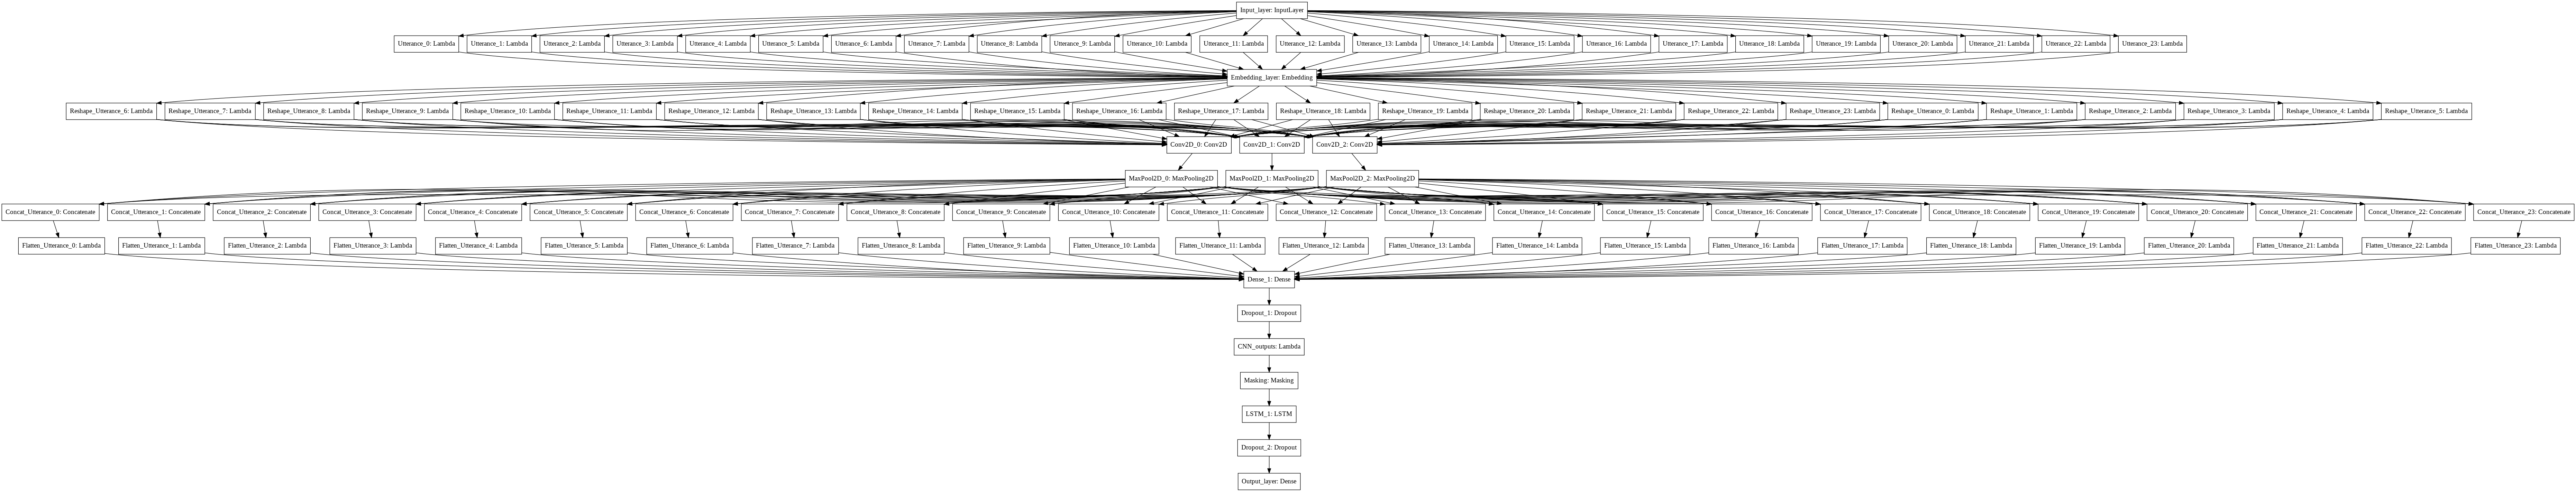

In [10]:
tf.keras.utils.plot_model(model,to_file='bc-LSTM.png')

<h2>2.2. Loss function

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

In [12]:
def loss_function(real, pred):
    #Identify zeros in real tensor/Creating masking tensor
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #Calculate log loss for each class
    loss_ = loss_object(real, pred)
    #Change data type of mask
    mask = tf.cast(mask, dtype=loss_.dtype)
    #Calculate loss considering masking
    loss_ *= mask
    return tf.reduce_mean(loss_)

<h2>2.3. Data Pipeline

In [13]:
#Tensorflow data generator
def data_generator(X,y,BATCH_SIZE,shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(BATCH_SIZE*10).batch(BATCH_SIZE,drop_remainder=True)
    else:
        dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

<h2>2.4. Model Training

In [14]:
#Create folder to save model weights
if not os.path.isdir('model_save'):
    os.makedirs('model_save')

In [15]:
tf.keras.backend.clear_session()

#Set Parameters
BATCH_SIZE = 64
epochs = 50

#Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=loss_function)

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Reduce learning rate by 10% if validation loss does not decrease from last 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, verbose=1, patience=2,min_lr=0.00001)

#Decrease learning rate by LS_rate% after every LS_pat epochs
LS_rate = 0.05
LS_pat = 5
def scheduler(epoch,lr):
    if (epoch%LS_pat==0) & (epoch>1):
        lr = lr*(1-LS_rate)
        return lr
    else:
        return lr
reduce_lr_2 = LearningRateScheduler(scheduler, verbose=1)

#Stop training if val_loss does not decrease in last 5 epochs
terminate = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min',restore_best_weights=True)

#Callback list
callback_list = [checkpoint,reduce_lr,reduce_lr_2,terminate]

#Generate data
train = data_generator(X_train,y_train,BATCH_SIZE=BATCH_SIZE,shuffle=True)
val = data_generator(X_val,y_val,BATCH_SIZE=BATCH_SIZE,shuffle=False)

#Train model
history1 = model.fit(train,epochs=epochs,validation_data=val,callbacks=callback_list)


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.6512
Epoch 00001: val_loss improved from inf to 0.57270, saving model to model_save/weights-01-0.6512.hdf5
17/17 [==============================] - 6s 360ms/step - loss: 0.6512 - val_loss: 0.5727 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.6318
Epoch 00002: val_loss improved from 0.57270 to 0.54164, saving model to model_save/weights-02-0.6318.hdf5
17/17 [==============================] - 4s 249ms/step - loss: 0.6318 - val_loss: 0.5416 - lr: 1.0000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.6138
Epoch 00003: val_loss improved from 0.54164 to 0.52379, saving model to model_save/weights-03-0.6138

In [16]:
joblib.dump(history1.history,'history1')

['history1']

In [17]:
#Save weights
model.save_weights('best_model1.h5')

In [18]:
h1 = joblib.load('history1')

In [19]:
loss = h1['loss']
val_loss = h1['val_loss']

Text(0.5, 1.0, 'Loss Vs No of epochs')

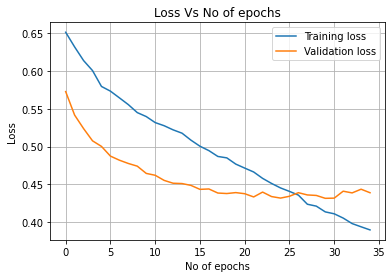

In [20]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')

In [21]:
#Load weights
model.load_weights('best_model1.h5')

<h2>2.5. Model Evaluation

In [23]:
model.evaluate(X_train,y_train,batch_size=BATCH_SIZE)

18/18 [==============================] - 1s 70ms/step - loss: 0.3714


0.37142398953437805

In [24]:
model.evaluate(X_val,y_val,batch_size=BATCH_SIZE)

3/3 [==============================] - 0s 32ms/step - loss: 0.4331


0.4331280589103699

In [25]:
model.evaluate(X_test,y_test,batch_size=BATCH_SIZE)

3/3 [==============================] - 0s 45ms/step - loss: 0.4494


0.44940683245658875

In [26]:
def predict_label(x):
    """
    Get predictions for single dialogue
    """
    a = model.predict(np.expand_dims(x,0))
    return [i.argmax() for i in a[0]]

In [27]:
#Get predictions from model
y_test_pred = np.array([predict_label(i) for i in tqdm(X_test)])

100%|██████████| 134/134 [00:07<00:00, 18.34it/s]


In [28]:
#Get true and pred labels after dropping padded labels (Needed for plotting confusion matrix)
def generate_true_pred_labels(true,pred):
    true_label = []
    pred_label = []
    for i,j in tqdm(zip(true,pred)):
        if 0 in i:
            index = min(np.where(i==0)[0])
        else:
            index = len(i)
        for k in range(index):
            true_label.append(i[k])
            pred_label.append(j[k])
    return true_label, pred_label

In [29]:
test_actual, test_pred = generate_true_pred_labels(y_test,y_test_pred)

134it [00:00, 29255.99it/s]


In [30]:
def plot_matrices(test_y, predict_y):
    """
    Plot Confusion, Recall and Precision Matrix
    """
    
    #Confusion Matrix
    C = confusion_matrix(test_y, predict_y)
    #Recall Matrix
    #Sum of each row of recall matrix is 1
    A =(((C.T)/(C.sum(axis=1))).T)
    #Precision Matrix
    #Sum of each column of precision matrix is 1
    B =(C/C.sum(axis=0))
    
    labels = label_index.values()
    cmap=sns.light_palette("purple")
    
    plt.figure(figsize=(10,5))
    plt.subplot(111)
    plt.title('Confusion Matrix')
    sns.heatmap(C, annot=True,square=True,cmap=cmap,fmt=".1f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Precision Matrix')
    sns.heatmap(B, annot=True,square=True,cmap=cmap,fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    
    plt.subplot(122)
    plt.title('Recall Matrix')
    sns.heatmap(A, annot=True,square=True,cmap=cmap,fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')

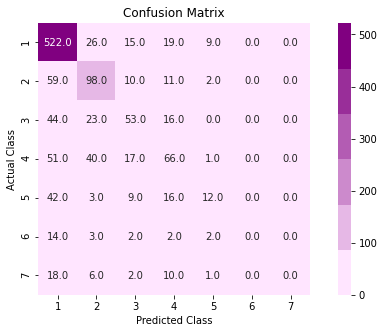

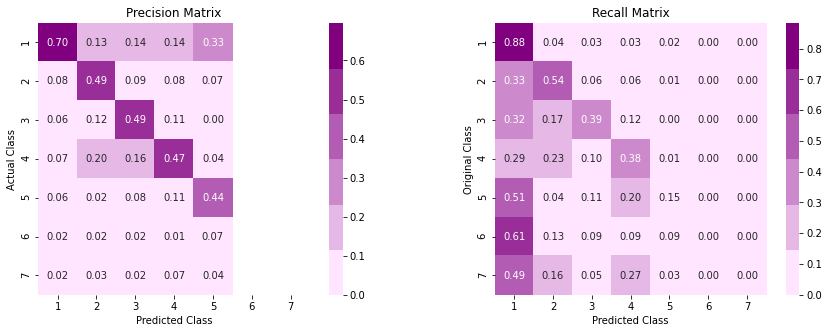

In [31]:
plot_matrices(test_actual,test_pred)